# Native data acquisition
In this tutorial we run some measurements, and we push the data directly to the QHarbor platform.

You can download this jupyter notebook and more examples from [here](https://github.com/qEncoder/dataQruiser/tree/main/examples).

# Run a measurement with qdrive
This measurement loop pushes data directly to a qdrive dataset. You can see the live dataset populating in the dataQruiser app

In [1]:
from qdrive.measurement.sweeps import do0D, do1D, do2D
from utils import dac, measure_param_1, measure_param_2 # import the mock instruments

# 1D Sweep
dsq = do1D("1D Sweep Native", 
        dac.ch1, -250, 250, 300, 0.02,   # sweep parameter, start, stop, n_points, delay
        measure_param_1, measure_param_2,
        reset_param=True,
        )
dsq.attributes = {'sample': 'Q7-R3', 'setup': 'Fridge B256'}

dsq = do2D("2D Sweep Native", 
          dac.ch1, 0, 400, 100, 0,
          dac.ch2, -100, 100, 100, 0.0007, 
          measure_param_1,
          reset_param=True
          )
dsq.attributes = {'sample': 'Q7-R3', 'setup': 'Fridge B256'}


Starting measurement with uuid : 51547ffa-95c0-495e-bc40-e369efcd23ef - 1D Sweep Native


Measurement Progress: 100%|██████████| 300/300 [00:07<00:00, 39.39it/s]


Starting measurement with uuid : 589ae392-1454-4050-b012-d4455c0ae2eb - 2D Sweep Native



Measurement Progress: 100%|██████████| 10000/10000 [00:09<00:00, 1006.86it/s]


# Run a measurement and perform an analysis


Starting measurement with uuid : 4baa5ba6-ef7c-451a-ace1-aa22277d5cda - 1D Sweep Native with Analysis


Measurement Progress: 100%|██████████| 300/300 [00:03<00:00, 79.42it/s]
/var/folders/ng/2zdj323d1fs3r8sbfscgfmchnwbxp4/T/ipykernel_22807/2542818135.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.optimize import curve_fit


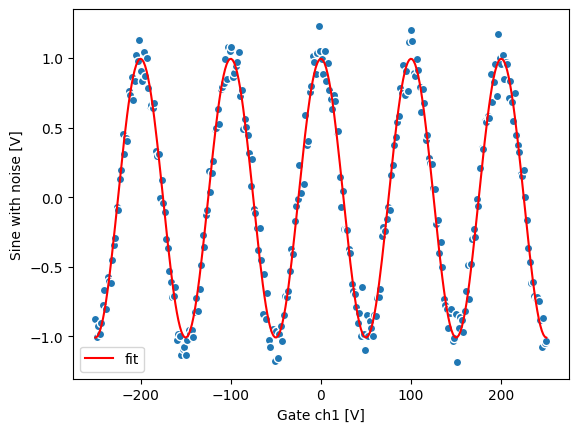

In [2]:
# 1D Sweep
dsq = do1D("1D Sweep Native with Analysis", 
        dac.ch1, -250, 250, 300, 0.01,   # sweep parameter, start, stop, n_points, delay
        measure_param_1, 
        reset_param=True
        )

# ANALYSIS: fit the data
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
import numpy as np

def cos_func(x, amp, freq, phase, offset):
    return amp * np.cos(2*np.pi*freq*x + phase) + offset

# Get the xarray dataset
dsx = dsq['measurement.hdf5'].xarray

# Fit the data
popt, pcov = curve_fit(cos_func, dsx.ch1, dsx.measure_param_1, p0=[1.0, 0.01, 0, 0])
fit_data = cos_func(dsx.ch1, *popt)

# Add fit data to dataset and link variables for joint plotting
dsx['fit'] = fit_data
dsx['fit'].attrs.update({'__join_plot': 'measure_param_1'})
dsx.measure_param_1.attrs.update({'__join_plot': 'fit'})
dsq['analysis.hdf5'] = dsx

# Plot the fit
dsx.measure_param_1.plot.scatter()
plt.plot(dsx.ch1, fit_data, 'r-', label='fit')
plt.legend()
plt.savefig('data/fit.png')

# UPLOAD the analysis to the database
dsq['fit.png'] = Path('data/fit.png')
dsq['fit_params.json'] = {
    'amplitude': popt[0],
    'frequency': popt[1],
    'phase': popt[2],
    'offset': popt[3]
}

# Custom measurement loop

In [3]:
import time
import numpy as np

from qdrive.measurement.measurement import Measurement
from qdrive.demo.station import get_station

n_x_vals = 100
n_y_vals = 150

station = get_station()

# Combine the previous 1D and 2D experiments in a single experiment

# 1 load relevant instruments
graph_instr_1D = station.one_D_graph_instr
graph_instr_1D.set_shape(n_x_vals)
graph_instr_2D = station.two_D_graph_instr
graph_instr_2D.set_shape(n_x_vals, n_y_vals)

dac = station.QH_dac

# 2 create a measurement object
meas = Measurement("combined_1D_and_2D_measurement")
meas.register_m_param(graph_instr_1D.m_param, dac.ch1)
meas.register_m_param(graph_instr_2D.m_param, dac.ch1, dac.ch2)

# 3 run the measurement
with meas.measure() as data_collector:
    for ch1_voltage in np.arange(0,n_y_vals,1):
        dac.ch1.set(ch1_voltage)
        # provide collection of m_params and their setpoints here
        data_collector.add_data({dac.ch1 : ch1_voltage, graph_instr_1D.m_param : graph_instr_1D.m_param()})

        for ch2_voltage in np.arange(0,n_x_vals,1):
            dac.ch2.set(ch2_voltage)
            data_collector.add_data({dac.ch1 : ch1_voltage,
                                        dac.ch2 : ch2_voltage,
                                        graph_instr_2D.m_param : graph_instr_2D.m_param()})

            time.sleep(0.001)

ds = meas.dataset


Starting measurement with uuid : 60a534aa-a935-49c9-93fc-3f01ba5a40b0 - combined_1D_and_2D_measurement
